# Sentiment Analysis of OTR App Store Reviews

In [1]:
# !pip install app_store_scraper
# !pip install wordcloud
# !pip install textblob
# !pip install pandas_profiling
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import string
import emoji
import warnings
warnings.filterwarnings("ignore")

## 1. Data Collection

In [3]:
from app_store_scraper import AppStore

otr_reviews = 
AppStore(country='us', app_name='onetouch-reveal', app_id = '651293599')

otr_reviews.review(how_many=1000000)

2022-08-13 16:31:41,587 [INFO] Base - Initialised: AppStore('us', 'onetouch-reveal', 651293599)
2022-08-13 16:31:41,588 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/onetouch-reveal/id651293599
2022-08-13 16:31:46,798 [INFO] Base - [id:651293599] Fetched 880 reviews (880 fetched in total)
2022-08-13 16:33:59,914 [WARNING] urllib3.connectionpool - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fea94ec05d0>: Failed to establish a new connection: [Errno 101] Network is unreachable')': /v1/catalog/us/apps/651293599/reviews?l=en-GB&offset=1280&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac
2022-08-13 16:34:00,221 [INFO] Base - [id:651293599] Fetched 1300 reviews (1300 fetched in total)
2022-08-13 16:36:15,082 [WARNING] urllib3.connectionpool - Retrying (Retry(total=2, connect=None, read=None, redirect=None, statu

In [4]:
df = pd.DataFrame(np.array(otr_reviews.reviews),columns=['review'])
df_otr = df.join(pd.DataFrame(df.pop('review').tolist()))

In [5]:
df = df_otr
# Drop index column and Extract df into a csv file
df_otr.to_csv('data/OTR-AppStore-Reviews.csv', index=False)

df_otr.head(5)

,date,isEdited,review,title,userName,rating,developerResponse
0,2020-02-01 15:29:44,False,The app is very useful to me as someone who wa...,Carlos E. Jean-Gilles,Carlos E. Jean-Gilles,5,NaN
1,2017-11-30 04:22:47,False,We got this for my daughter it is amazing. It ...,Amazing!! Love it!!!,III% Alumnist,5,NaN
2,2021-12-27 19:31:14,False,Had I never used another app for tracking my b...,Could use a lot of improvement,523Abc,2,"{'id': 27256128, 'body': 'Thank you for your r..."
3,2019-04-14 12:15:42,False,With so many glucose apps out there I hoped th...,Could be better,HiMMS attendee,1,NaN
4,2021-06-04 03:04:29,False,I’ve used this app for years with little probl...,Version 5.3 completely broken,Ssteva,1,"{'id': 23342360, 'body': 'We apologize for the..."


## 2. Exploratory Data Analysis (EDA) 

In [6]:
from pandas_profiling import ProfileReport

ProfileReport(df_otr).to_file(output_file='appstore-eda.html')

2022-08-13 16:36:16,011 [INFO] visions.backends - Pandas backend loaded 1.3.5
2022-08-13 16:36:16,018 [INFO] visions.backends - Numpy backend loaded 1.19.5
2022-08-13 16:36:16,059 [INFO] visions.backends - Pyspark backend loaded 3.3.0
2022-08-13 16:36:16,060 [INFO] visions.backends - Python backend loaded


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Sentiment Analysis

In [7]:
df=df[["review", "title", "rating"]]
df

,review,title,rating
0,The app is very useful to me as someone who wa...,Carlos E. Jean-Gilles,5
1,We got this for my daughter it is amazing. It ...,Amazing!! Love it!!!,5
2,Had I never used another app for tracking my b...,Could use a lot of improvement,2
3,With so many glucose apps out there I hoped th...,Could be better,1
4,I’ve used this app for years with little probl...,Version 5.3 completely broken,1
...,...,...,...
2688,2015/04/07 - After Update:\n\nMany new feature...,Dangerously Lacking,1
2689,I been manually tracking my blood sugar since ...,Very Poor update,1
2690,I am an MD with diabetes.\n\nApp is nice to sy...,Needs improvement,1
2691,I eagerly awaited receiving the OneTouch Verio...,One star is too generous for this app,1


In [8]:
df['review'] = df['review'].astype(str)
df['review']

0       The app is very useful to me as someone who wa...
1       We got this for my daughter it is amazing. It ...
2       Had I never used another app for tracking my b...
3       With so many glucose apps out there I hoped th...
4       I’ve used this app for years with little probl...
                              ...                        
2688    2015/04/07 - After Update:\n\nMany new feature...
2689    I been manually tracking my blood sugar since ...
2690    I am an MD with diabetes.\n\nApp is nice to sy...
2691    I eagerly awaited receiving the OneTouch Verio...
2692    The reporting features on this Health app or w...
Name: review, Length: 2693, dtype: object

In [9]:
def senti_polarity(x):
    if x is not None:
       return TextBlob(x).sentiment.polarity

def senti_subjectivity(x):
    if x is not None:
       return TextBlob(x).sentiment.subjectivity

def getAnalysis(score):
    if score < 0.25:
        return 'Negative'
    # elif score == 0:
    #     return 'Neutral'
    else:
        return 'Positive'

# df["Sentiment_score"]= df["extracted_emojis"].apply(senti_sc)

#Create two new columns ‘Subjectivity’ & ‘Polarity’
df['sentiment_polarity'] = df['review'].apply(senti_polarity)
df['sentiment_analysis'] = df['sentiment_polarity'].apply(getAnalysis)
df['sentiment_subjectivity'] = df['review'].apply(senti_subjectivity)

df

,review,title,rating,sentiment_polarity,sentiment_analysis,sentiment_subjectivity
0,The app is very useful to me as someone who wa...,Carlos E. Jean-Gilles,5,0.231890,Negative,0.555957
1,We got this for my daughter it is amazing. It ...,Amazing!! Love it!!!,5,0.132840,Negative,0.368596
2,Had I never used another app for tracking my b...,Could use a lot of improvement,2,0.343139,Positive,0.613247
3,With so many glucose apps out there I hoped th...,Could be better,1,0.125585,Negative,0.496345
4,I’ve used this app for years with little probl...,Version 5.3 completely broken,1,0.058144,Negative,0.395292
...,...,...,...,...,...,...
2688,2015/04/07 - After Update:\n\nMany new feature...,Dangerously Lacking,1,-0.027384,Negative,0.543699
2689,I been manually tracking my blood sugar since ...,Very Poor update,1,-0.298462,Negative,0.524615
2690,I am an MD with diabetes.\n\nApp is nice to sy...,Needs improvement,1,0.433333,Positive,0.666667
2691,I eagerly awaited receiving the OneTouch Verio...,One star is too generous for this app,1,0.027329,Negative,0.436833


In [10]:
df.to_csv('result/OTR-AppStore-SentimentAnalysis.csv', index=False)

## 4. Insights

In [11]:
#positive review
df_neg = df[df['sentiment_analysis'] == 'Negative']


In [12]:
#positive review
df_pos = df[df['sentiment_analysis'] == 'Positive']


### a. Graphs

<AxesSubplot:xlabel='sentiment_polarity', ylabel='Count'>

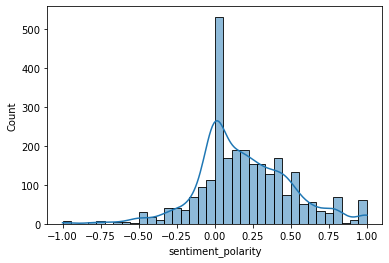

In [13]:
# Count Plot for Sentiment polarity
sns.histplot(data = df['sentiment_polarity'], kde = True)

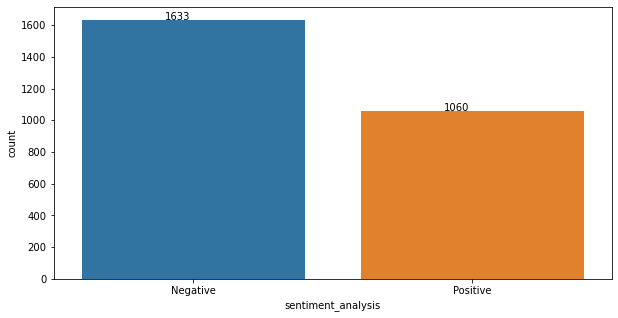

In [39]:
# Count Plot for Sentiment analysis

plt.figure(figsize=(10, 5))
b1 = sns.countplot(x="sentiment_analysis", data=df)

for p in b1.patches:
    b1.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.01))


#plt.savefig("test.jpg", dpi=100,bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='sentiment_subjectivity', ylabel='Count'>

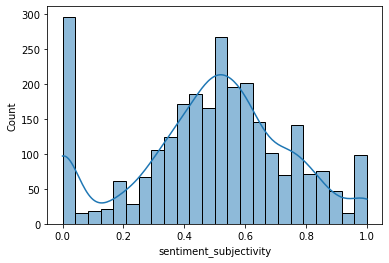

In [15]:
# Count Plot for Sentiment subjectivity
sns.histplot(data = df['sentiment_subjectivity'], kde = True)

### b. Wordcloud

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    text = data.tolist()
    text = ' '.join(text).lower()
    
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(text)

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    rel_count = wordcloud.words_
    word_count = wordcloud.process_text(text)
    
    plt.imshow(wordcloud)
    plt.show()
    return rel_count,word_count 

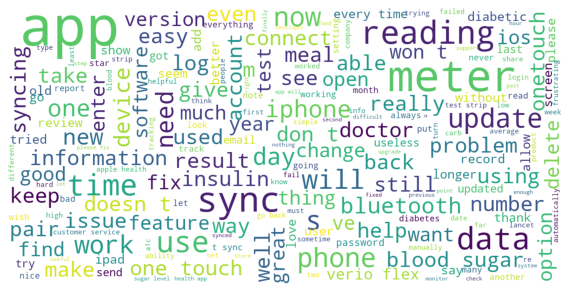

In [17]:
# print wordcloud
n_rel, n_word = show_wordcloud(df_neg["review"])

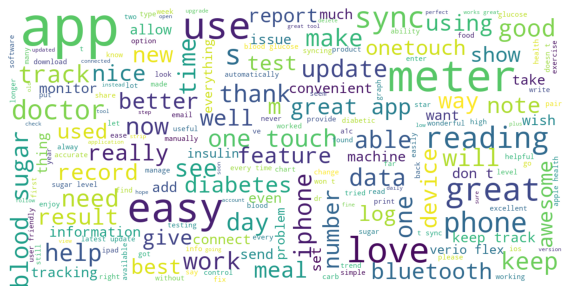

In [18]:
# print wordcloud
p_rel, p_word = show_wordcloud(df_pos["review"])

### c. Word count

In [19]:
# concat values from 2 dic, if same keys
def merge_dict(d1,d2):
    ds = [d1, d2]
    d = {}
    for k in d1.keys():
      d[k] = tuple(d[k] for d in ds)
    return d

In [20]:
merge_dict(n_rel,n_word)

{'app': (1.0, 1498),
 'meter': (0.554739652870494, 831),
 'sync': (0.32443257676902537, 486),
 'reading': (0.2596795727636849, 389),
 'data': (0.2336448598130841, 350),
 'use': (0.21895861148197596, 328),
 'time': (0.21762349799732977, 326),
 'now': (0.1822429906542056, 273),
 'will': (0.17823765020026702, 267),
 'phone': (0.17423230974632845, 261),
 'update': (0.16889185580774366, 253),
 's': (0.16488651535380508, 247),
 'work': (0.13951935914552738, 209),
 'need': (0.1315086782376502, 197),
 'day': (0.12750333778371162, 191),
 'one': (0.12349799732977303, 185),
 'iphone': (0.12016021361815754, 180),
 'device': (0.1081441922563418, 162),
 'bluetooth': (0.1048064085447263, 157),
 'new': (0.1041388518024032, 156),
 'make': (0.09679572763684913, 145),
 'way': (0.09412550066755675, 141),
 'see': (0.08945260347129506, 134),
 'don t': (0.08811748998664887, 132),
 'easy': (0.08678237650200267, 130),
 'problem': (0.08544726301735647, 128),
 'one touch': (0.08411214953271028, 126),
 'blood sug

In [21]:
merge_dict(p_rel,p_word)

{'app': (1.0, 658),
 'meter': (0.5303951367781155, 349),
 'easy': (0.4696048632218845, 309),
 'use': (0.4072948328267477, 268),
 'love': (0.3601823708206687, 237),
 'great': (0.31458966565349544, 207),
 'sync': (0.270516717325228, 178),
 'reading': (0.25835866261398177, 170),
 'phone': (0.22188449848024316, 146),
 's': (0.21428571428571427, 141),
 'doctor': (0.18693009118541035, 123),
 'work': (0.14285714285714285, 94),
 'time': (0.14285714285714285, 94),
 'see': (0.1413373860182371, 93),
 'make': (0.13829787234042554, 91),
 'track': (0.13677811550151975, 90),
 'able': (0.13677811550151975, 90),
 'now': (0.1337386018237082, 88),
 'help': (0.13221884498480244, 87),
 'iphone': (0.12917933130699089, 85),
 'one touch': (0.12917933130699089, 85),
 'data': (0.12310030395136778, 81),
 'blood sugar': (0.12158054711246201, 80),
 'keep': (0.11854103343465046, 78),
 'good': (0.11854103343465046, 78),
 'update': (0.11550151975683891, 76),
 'one': (0.11398176291793313, 75),
 'will': (0.113981762917

### d. Key Factor Filters

#### 1. mean score  for word


In [22]:
df_neg[df_neg['review'].str.contains("bluetooth")]['rating'].mean()

# df_pos[df_pos['review'].str.contains("love")]['rating'].mean()

3.1538461538461537

#### 2. relative %  of word for each score 

In [23]:
df_neg[df_neg['review'].str.contains("meter")].groupby('rating')['rating'].count()/df_neg[df_neg['review'].str.contains("meter")]['rating'].count() * 100

# df_neg[df_neg['review'].str.contains("meter")].groupby('rating')['rating'].count()
    

rating
1    36.042403
2    12.897527
3    12.720848
4     9.893993
5    28.445230
Name: rating, dtype: float64

In [24]:
# define empty dataframe to store matrix
def rating_df():
    return pd.DataFrame(columns=[1,2,3,4,5])

def score_and_keyword_occurence_matrix(source_df, keyword, matrix_df): 
    # '(?i)' to ignore casing using regex
    word_score_count = np.array(source_df[source_df['review'].str.contains('(?i)'+keyword)].groupby('rating')['rating'].count()/source_df[source_df['review'].str.contains('(?i)'+keyword)]['rating'].count() * 100)    
    if len(word_score_count) < 5:
        c = [0.0] * (5-len(word_score_count))
        kw = word_score_count.tolist()
        kw.extend(c)
        matrix_df.loc[keyword] = np.array(kw)    
    else:
        matrix_df.loc[keyword] = word_score_count
    return matrix_df

In [25]:
def plot_bar(matrix_df):
    df_bar = matrix_df.transpose()
    ycol = df_bar.columns.tolist()
    df_bar = df_bar.reset_index()
    # plotting graph
    print(df_bar)
    df_bar.plot(x="index", y=ycol, kind="bar", figsize=(7, 5))

In [26]:
matrix_df_neg = rating_df()
matrix_df_pos = rating_df()

In [27]:
# positive reviews keywords: easy to use, keep track, great app, doctor, blood sugar
score_and_keyword_occurence_matrix(df_pos, 'keep track', matrix_df_pos)

,1,2,3,4,5
keep track,5.714286,8.571429,85.714286,0.0,0.0


In [28]:
# negative reviews keywords: 
#  update(version update issues), privacy, meter(app functional), reading(tracking), meal(bedtime and meal time)
score_and_keyword_occurence_matrix(df_neg, 'meal', matrix_df_neg)

,1,2,3,4,5
meal,18.461538,13.846154,13.846154,24.615385,29.230769


   index       meal
0      1  18.461538
1      2  13.846154
2      3  13.846154
3      4  24.615385
4      5  29.230769


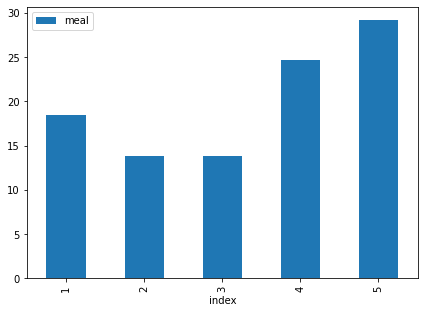

In [29]:
plot_bar(matrix_df_neg)

   index  keep track
0      1    5.714286
1      2    8.571429
2      3   85.714286
3      4    0.000000
4      5    0.000000


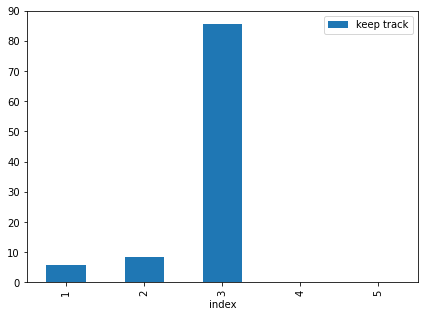

In [30]:
plot_bar(matrix_df_pos)

#### 3. 

In [31]:
df_neg[df_neg['review'].str.contains("(?i)privacy")].sort_values(by=['rating'], ascending=True).head(10)

,review,title,rating,sentiment_polarity,sentiment_analysis,sentiment_subjectivity
507,A new update to the app requires agreement tha...,Sending data to other countries…,1,0.003788,Negative,0.318182
2575,Well they added HealthKit. HealthKit plots the...,"Love the meter, but the new app versions make ...",1,0.068878,Negative,0.352041
2358,The app forces you to create an account and sa...,Forced to create an account to take reading,1,0.000000,Negative,0.400000
2179,Lost all my data in the update to 2.0. All the...,ALL MY DATA LOST & NO DATA PRIVACY in update 2.0,1,0.180000,Negative,0.378472
2121,I was given this new meter by my physician. I ...,I knew this app would stink...,1,-0.010943,Negative,0.441100
2044,App is junk and too privacy intrusive. 👎,Spyware,1,0.000000,Negative,0.000000
1481,"I fail to understand why they need email, name...",Loss of privacy,1,0.087500,Negative,0.433333
1090,I allowed a friend who I was worried about to ...,Not helpful to ban deletion,1,-0.395000,Negative,0.602500
2676,"People, if you agree to the user/end license a...",SHARING GLUCOSE LEVELS?!?!,1,0.128333,Negative,0.526667
2687,Slight improvement to upgrade. My blood sugar...,bad change -- want old app back,1,0.091407,Negative,0.374015


In [32]:
df['review'][508]

'It needs more features, and easier syncing with stuff like the Kaiser app, but it syncs up no problems, and keeps track of a lot information.'